# Evaluting the Motion Generation Diffusion Prior

## Load model and dataset

In [1]:
# This code is based on https://github.com/openai/guided-diffusion
"""
Generate a large batch of image samples from a model and save them as a large
numpy array. This can be used to produce samples for FID evaluation.
"""
from utils.fixseed import fixseed
import os
import tqdm
import copy
import pickle
import numpy as np
import torch
from utils.model_util import create_model_and_diffusion, load_model_wo_clip
from utils import dist_util
from model.cfg_sampler import ClassifierFreeSampleModel
from data_loaders.get_data import get_dataset_loader
from data_loaders.humanml.scripts.motion_process import recover_from_ric
import data_loaders.humanml.utils.paramUtil as paramUtil
from data_loaders.humanml.utils.plot_script import plot_3d_motion
import matplotlib.pyplot as plt

class Args(object):
    model_path = './save/humanml_trans_enc_512/model000200000.pt'
    seed = 0
    output_dir = ''
    dataset = 'humanml'
    motion_length = 6.0
    input_text = ''
    text_prompt = ''
    device = 0
    latent_dim = 512
    layers = 8
    cond_mask_prob = 0.1
    arch = 'trans_enc'
    emb_trans_dec = False
    noise_schedule = 'cosine'
    sigma_small = True
    lambda_vel = 0.0
    lambda_rcxyz = 0.0
    lambda_fc = 0.0
    guidance_param = 2.5
    num_samples = 10
    batch_size = 64
    num_repetitions = 3
    num_samples = 1
args = Args()

In [2]:
fixseed(args.seed)
out_path = args.output_dir
name = os.path.basename(os.path.dirname(args.model_path))
niter = os.path.basename(args.model_path).replace('model', '').replace('.pt', '')
max_frames = 196 if args.dataset in ['kit', 'humanml'] else 60
fps = 12.5 if args.dataset == 'kit' else 20
n_frames = min(max_frames, int(args.motion_length*fps))
is_using_data = args.input_text == '' and args.text_prompt == ''
dist_util.setup_dist(args.device)
if out_path == '':
    out_path = os.path.join(os.path.dirname(args.model_path),
                            'samples_{}_{}_seed{}'.format(name, niter, args.seed))
    if args.text_prompt != '':
        out_path += '_' + args.text_prompt.replace(' ', '_').replace('.', '')
    elif args.input_text != '':
        out_path += '_' + os.path.basename(args.input_text).replace('.txt', '').replace(' ', '_').replace('.', '')

print("Creating model and diffusion...")
model, diffusion = create_model_and_diffusion(args)

print(f"Loading checkpoints from [{args.model_path}]...")
state_dict = torch.load(args.model_path, map_location='cpu')
load_model_wo_clip(model, state_dict)

if args.guidance_param != 1:
    model = ClassifierFreeSampleModel(model)   # wrapping model with the classifier-free sampler  # TODO - simplify
model.to(dist_util.dev())
model.eval()  # disable random masking

Creating model and diffusion...
TRANS_ENC init
EMBED TEXT
Loading CLIP...
Loading checkpoints from [./save/humanml_trans_enc_512/model000200000.pt]...


ClassifierFreeSampleModel(
  (model): MDM(
    (input_process): InputProcess(
      (poseEmbedding): Linear(in_features=263, out_features=512, bias=True)
    )
    (sequence_pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (seqTransEncoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1):

In [3]:
print('Loading dataset...')
texts = []
if args.text_prompt != '':
    texts = [args.text_prompt]
    args.num_samples = 1
elif args.input_text != '':
    assert os.path.exists(args.input_text)
    with open(args.input_text, 'r') as fr:
        texts = fr.readlines()
    texts = [s.replace('\n', '') for s in texts]
    args.num_samples = len(texts)

assert args.num_samples <= args.batch_size, \
    f'Please either increase batch_size({args.batch_size}) or reduce num_samples({args.num_samples})'
# So why do we need this check? In order to protect GPU from a memory overload in the following line.
# If your GPU can handle batch size larger then default, you can specify it through --batch_size flag.
# If it doesn't, and you still want to sample more prompts, run this script with different seeds
# (specify through the --seed flag)
args.batch_size = args.num_samples  # Sampling a single batch from the testset, with exactly args.num_samples
data = get_dataset_loader(name=args.dataset,
                          batch_size=args.batch_size,
                          num_frames=max_frames,
                          split='train',
                          hml_mode='train')
data.fixed_length = n_frames
total_num_samples = args.num_samples * args.num_repetitions

Loading dataset...
Reading ././dataset/humanml_opt.txt
Loading dataset t2m ...


100%|███████████████████████████████████| 23384/23384 [00:10<00:00, 2156.88it/s]

Pointer Pointing at 0


## Run diffusion and evaluate reconstructions

In [4]:
x, model_kwargs = next(iter(data))
x = x.to('cuda')

if args.guidance_param != 1:
    model_kwargs['y']['scale'] = torch.ones(args.batch_size, device=dist_util.dev()) * 10

In [5]:
model_kwargs

{'y': {'mask': tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True, False, False, False

In [6]:
def plot_motion(x, name):
    # Recover XYZ *positions* from HumanML3D vector representation
    x = torch.clone(x).detach()
    if model.data_rep == 'hml_vec':
        n_joints = 22 if x.shape[1] == 263 else 21
        x = data.dataset.t2m_dataset.inv_transform(x.cpu().permute(0, 2, 3, 1)).float()
        print(x.shape)
        x = recover_from_ric(x, n_joints)
        print(x.shape)
        x = x.view(-1, *x.shape[2:]).permute(0, 2, 3, 1)
        print(torch.min(torch.min(x, dim=1)[0], dim=-1)[0].shape)
        print('XYZ Min:', torch.min(torch.min(x, dim=1)[0], dim=-1)[0])
        print('XYZ Max:', torch.max(torch.max(x, dim=1)[0], dim=-1)[0])

    caption = model_kwargs['y']['text']
    print(caption)
    motion = x.cpu().numpy()
    print(motion.shape)
    length = model_kwargs['y']['lengths'].cpu().numpy()
    print(length)

    out_path = './debug_motions'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    caption = caption[0]
    length = length = length[0]
    motion = motion[0].transpose(2, 0, 1)[:length]

    skeleton = paramUtil.kit_kinematic_chain if args.dataset == 'kit' else paramUtil.t2m_kinematic_chain
    # caption = all_text[rep_i*args.batch_size + sample_i]
    # length = all_lengths[rep_i*args.batch_size + sample_i]
    # motion = all_motions[rep_i*args.batch_size + sample_i].transpose(2, 0, 1)[:length]
    save_file = name
    animation_save_path = os.path.join(out_path, save_file)
    if args.dataset == 'kit':
        motion *= 0.003  # scale for visualization
    elif args.dataset == 'humanml':
        motion *= 1.3  # scale for visualization
    plot_3d_motion(animation_save_path, skeleton, motion, title=caption, fps=fps)
    # Credit for visualization: https://github.com/EricGuo5513/text-to-motion

    abs_path = os.path.abspath(out_path)
    print(f'[Done] Results are at [{abs_path}]')

In [7]:
for i, sample in enumerate(diffusion.p_sample_loop_progressive(
    model,
    x.shape,
    noise=None,
    clip_denoised=False,
    denoised_fn=None,
    cond_fn=None,
    model_kwargs=model_kwargs,
    device='cuda',
    progress=True,
    skip_timesteps=0,
    init_image=x,
    randomize_class=False,
    cond_fn_with_grad=False,
    const_noise=False,
)):
    continue
out = sample["sample"]
xT = diffusion.q_sample(x, torch.tensor([diffusion.num_timesteps - 1], device='cuda'), noise=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
plot_motion(x, '0_sample_orig.mp4')
plot_motion(xT, '1_sample_diffused.mp4')
plot_motion(out, '2_sample_reconstruct.mp4')

torch.Size([1, 1, 196, 263])
torch.Size([1, 1, 196, 22, 3])
torch.Size([1, 3])
XYZ Min: tensor([[-2.3443,  0.0000, -0.0961]])
XYZ Max: tensor([[0.3780, 1.5725, 1.9672]])
['a person walks up towards the right.']
(1, 22, 3, 196)
[116]
[Done] Results are at [/usr/local/google/home/aescontrela/diffusion_motion_priors/motion-diffusion-model/debug_motions]
torch.Size([1, 1, 196, 263])
torch.Size([1, 1, 196, 22, 3])
torch.Size([1, 3])
XYZ Min: tensor([[-0.5985, -0.3732, -0.2791]])
XYZ Max: tensor([[0.6813, 1.7555, 2.0685]])
['a person walks up towards the right.']
(1, 22, 3, 196)
[116]
[Done] Results are at [/usr/local/google/home/aescontrela/diffusion_motion_priors/motion-diffusion-model/debug_motions]
torch.Size([1, 1, 196, 263])
torch.Size([1, 1, 196, 22, 3])
torch.Size([1, 3])
XYZ Min: tensor([[-1.6961,  0.0258, -0.1665]])
XYZ Max: tensor([[0.6901, 1.5581, 2.7332]])
['a person walks up towards the right.']
(1, 22, 3, 196)
[116]
[Done] Results are at [/usr/local/google/home/aescontrela/dif

In [9]:
print('mse(x0, pred_x0): {}'.format(torch.nn.functional.mse_loss(x, out)))
print('mse(x0, xT): {}'.format(torch.nn.functional.mse_loss(x, xT)))

mse(x0, pred_x0): 1.1579025983810425
mse(x0, xT): 1.5445654392242432


## Evaluate prior of trained model for in-distribution and ood initial sequences.

In [10]:
def eval_prior(model, data, n_t_samples, n_iters, guidance_param, t_value=None, shuffle_data=False, plot_histogram=False):
    eps_l2_all = []
    x0_l2_all = []

    iterator = iter(data)
    
    if t_value is not None:
        n_t_samples = 1
        assert isinstance(t_value, int), 't_value must be of type int'

    for _ in tqdm.trange(n_iters):
        with torch.no_grad():
            x0, model_kwargs = next(iterator)
            x0 = x0.to('cuda')
            if shuffle_data:
                x0 = x0[:, torch.randperm(x0.shape[1])]
                # idx = torch.randperm(x0.nelement())
                # x0 = x0.view(-1)[idx].view(x0.size())

            # add CFG scale to batch
            if args.guidance_param != 1:
                model_kwargs['y']['scale'] = torch.ones(args.batch_size, device=dist_util.dev()) * guidance_param

            per_trajectory_error = []
            x0_batched = torch.cat([x0] * n_t_samples)
            if t_value is not None:
                t_batched = torch.tensor([t_value] * n_t_samples, device='cuda', dtype=torch.long)
            else:
                t_batched = torch.randint(50, 950, size=(n_t_samples,), device='cuda', dtype=torch.long)
            eps_batched = torch.cat([torch.randn_like(x0)] * n_t_samples)
            xt = diffusion.q_sample(x0_batched, t_batched, eps_batched)
            out = diffusion.p_mean_variance(model, xt, t_batched, clip_denoised=False, denoised_fn=None, model_kwargs=model_kwargs)
            pred_x0 = out['pred_xstart'].detach()
            pred_eps = diffusion._predict_eps_from_xstart(xt, t_batched, pred_x0).detach()
            eps_l2 = torch.nn.functional.mse_loss(eps_batched, pred_eps)
            x0_l2 = torch.nn.functional.mse_loss(x0_batched, pred_x0)

            eps_l2_all.append(eps_l2.item())
            x0_l2_all.append(x0_l2.item())

    return eps_l2_all, x0_l2_all

In [11]:
model_real_eps_l2_all, model_real_x0_l2_all = eval_prior(model, data, 128, 500, 2.5, shuffle_data=False)

100%|█████████████████████████████████████████| 500/500 [01:11<00:00,  7.00it/s]


In [12]:
model_fake_eps_l2_all, model_fake_x0_l2_all = eval_prior(model, data, 128, 500, 2.5, shuffle_data=True)

100%|█████████████████████████████████████████| 500/500 [01:12<00:00,  6.94it/s]


## Plot histogram for eps error

In [13]:
def plot_histogram(in_dist, out_of_dist, bins=50, density=True, x_space=False):
    str_desc = 'x0' if x_space else 'eps'
    title = '{} - pred_{}'.format(str_desc, str_desc)
    # plt.title(title)
    print('IN DISTRIBUTION {} STATISTICS:'.format(str_desc))
    print("\tMEAN: {}\n\tMEDIAN: {}\n\tSTD: {}".format(
        np.mean(in_dist),
        np.median(in_dist),
        np.std(in_dist)))

    print('OUT OF DISTRIBUTION pred_{} STATISTICS:'.format(str_desc))
    print("\tMEAN: {}\n\tMEDIAN: {}\n\tSTD: {}".format(
        np.mean(out_of_dist),
        np.median(out_of_dist),
        np.std(out_of_dist)))    

    fig, axs = plt.subplots(1, 2)
    axs[0].hist(in_dist, bins=bins, density=True, label='in distribution', fc=(0, 0, 1, 0.5))
    axs[0].hist(out_of_dist, bins=bins, density=True, label='out of distribution', fc=(1, 0, 0, 0.5))
    axs[0].legend()
    axs[0].set_title(title)

    axs[1].hist(np.log(in_dist), bins=bins, density=True, label='in distribution', fc=(0, 0, 1, 0.5))
    axs[1].hist(np.log(out_of_dist), bins=bins, density=True, label='out of distribution', fc=(1, 0, 0, 0.5))
    axs[1].legend()
    axs[1].set_title('log({})'.format(title))

    plt.show()

IN DISTRIBUTION eps STATISTICS:
	MEAN: 0.34343668558076024
	MEDIAN: 0.2418210133910179
	STD: 0.3688361130353237
OUT OF DISTRIBUTION pred_eps STATISTICS:
	MEAN: 4.871167100906372
	MEDIAN: 3.5721324682235718
	STD: 4.199926853055728


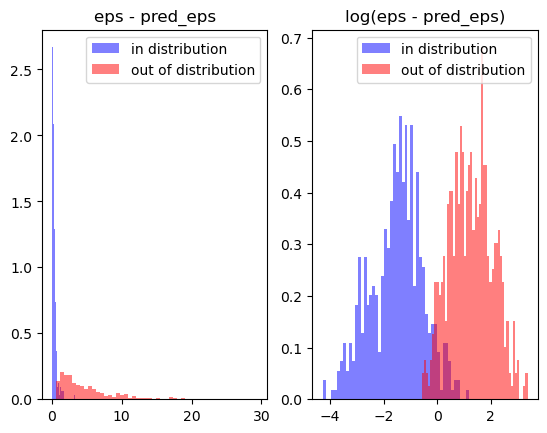

In [14]:
%matplotlib inline
plot_histogram(model_real_eps_l2_all, model_fake_eps_l2_all)

## Plot histogram for img error

IN DISTRIBUTION x0 STATISTICS:
	MEAN: 0.0714096935428679
	MEDIAN: 0.05794147774577141
	STD: 0.049716670988085035
OUT OF DISTRIBUTION pred_x0 STATISTICS:
	MEAN: 0.7571830987483263
	MEDIAN: 0.5386939644813538
	STD: 0.6206287502138212


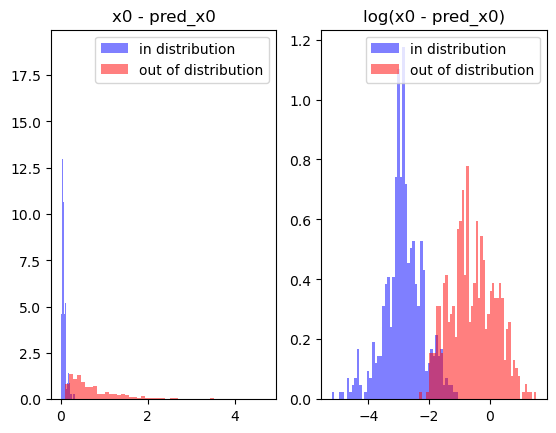

In [15]:
plot_histogram(model_real_x0_l2_all, model_fake_x0_l2_all, x_space=True)

# Sweep t value and guidance_param

In [16]:
guidance_params = np.linspace(0, 25, 11)
t_values = np.linspace(50, 950, 19).astype(np.int64)

In [17]:
from collections import defaultdict

sweep_outputs = defaultdict(lambda: {})
for gp in guidance_params:
    for t in t_values:
        real_eps, real_x0 = eval_prior(model, data, 64, 300, gp, t_value=int(t), shuffle_data=False)
        fake_eps, fake_x0 = eval_prior(model, data, 64, 300, gp, t_value=int(t), shuffle_data=True)
        reps, rx0, feps, fx0 = torch.tensor(real_eps), torch.tensor(real_x0), torch.tensor(fake_eps), torch.tensor(fake_x0)
        sweep_outputs[str(gp)][str(int(t))] = {
            'reps': reps[~torch.isnan(reps)],
            'rx0': rx0[~torch.isnan(rx0)],
            'feps': feps[~torch.isnan(feps)],
            'fx0': fx0[~torch.isnan(fx0)]
        }

100%|█████████████████████████████████████████| 300/300 [00:07<00:00, 37.63it/s]


In [18]:
sweep_outputs2 = dict(copy.deepcopy(sweep_outputs))

for k in sweep_outputs2.keys():
    for l in sweep_outputs2[k].keys():
        for m in sweep_outputs2[k][l].keys():
            sweep_outputs2[k][l][m] = sweep_outputs2[k][l][m].cpu().numpy()

with open('sweep.pickle', 'wb') as handle:
    pickle.dump(sweep_outputs2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sweep.pickle', 'rb') as handle:
    b = pickle.load(handle)

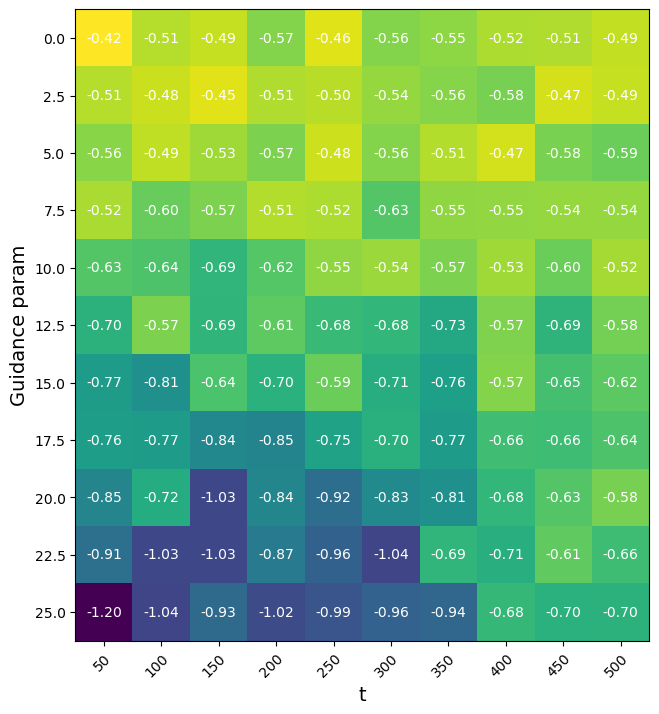

In [23]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

gp_range = [0, 25]
t_range = [50, 500]

plot_guidance_params = []
for guidance_param in guidance_params:
    if (guidance_param >= gp_range[0]) & (guidance_param <= gp_range[1]):
        plot_guidance_params.append(guidance_param)

plot_t_values = []
for t_value in t_values:
    if (t_value >= t_range[0]) & (t_value <= t_range[1]):
        plot_t_values.append(t_value)

reps_mean_arr = np.zeros((len(plot_guidance_params), len(plot_t_values)))

for i, gp in enumerate(plot_guidance_params):
    for j, t in enumerate(plot_t_values):
        reps_mean_arr[i][j] = (
            np.median(sweep_outputs[str(gp)][str(int(t))]['rx0']) -
            np.median(sweep_outputs[str(gp)][str(int(t))]['fx0'])
        )

guidance_param_str = [str(gp) for gp in plot_guidance_params]
t_value_str = [str(int(t)) for t in plot_t_values]

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(reps_mean_arr)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(t_value_str)), labels=t_value_str)
ax.set_yticks(np.arange(len(guidance_param_str)), labels=guidance_param_str)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(plot_guidance_params)):
    for j in range(len(plot_t_values)):
        text = ax.text(j, i, '%.2f'%reps_mean_arr[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.xlabel('t', fontsize=14)
plt.ylabel('Guidance param', fontsize=14)
plt.show()

Guidance param = 2.5
Diffusion t = 50
IN DISTRIBUTION eps STATISTICS:
	MEAN: 5.847363471984863
	MEDIAN: 4.07908821105957
	STD: 5.893640518188477
OUT OF DISTRIBUTION pred_eps STATISTICS:
	MEAN: 87.74747467041016
	MEDIAN: 64.76313018798828
	STD: 68.27157592773438


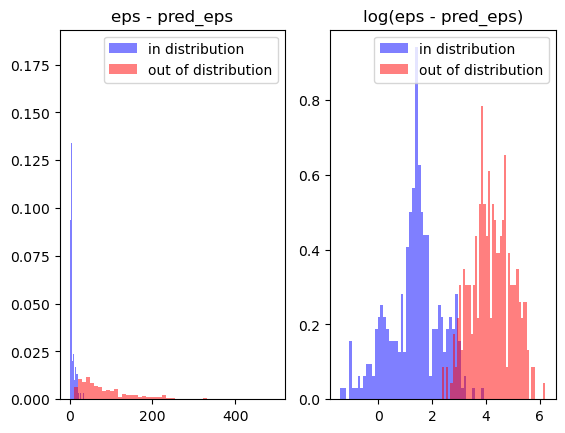

In [37]:
GP = 2.5
t = 50

print('Guidance param = {}'.format(GP))
print('Diffusion t = {}'.format(t))

plot_histogram(
    sweep_outputs[str(GP)][str(t)]['reps'].cpu().numpy(),
    sweep_outputs[str(GP)][str(t)]['feps'].cpu().numpy(),
    x_space=False)

Guidance param = 2.5
Diffusion t = 50
IN DISTRIBUTION x0 STATISTICS:
	MEAN: 0.04879254475235939
	MEDIAN: 0.034037407487630844
	STD: 0.049178704619407654
OUT OF DISTRIBUTION pred_x0 STATISTICS:
	MEAN: 0.7321971654891968
	MEDIAN: 0.5404074192047119
	STD: 0.5696831345558167


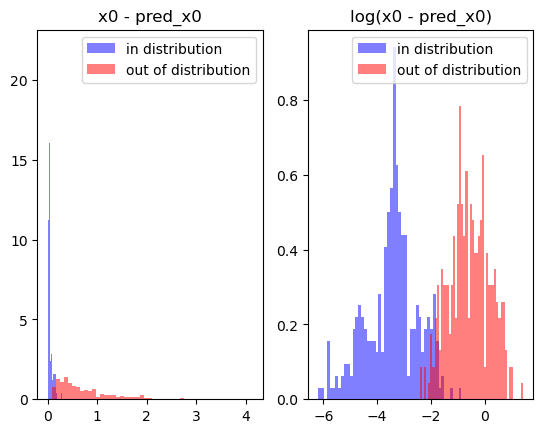

In [40]:
GP = 2.5
t = 50

print('Guidance param = {}'.format(GP))
print('Diffusion t = {}'.format(t))

plot_histogram(
    sweep_outputs[str(GP)][str(t)]['rx0'].cpu().numpy(),
    sweep_outputs[str(GP)][str(t)]['fx0'].cpu().numpy(),
    x_space=True)